# Импорт библиотек

In [124]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Загрузка данных

(np.float64(-0.5), np.float64(497.5), np.float64(497.5), np.float64(-0.5))

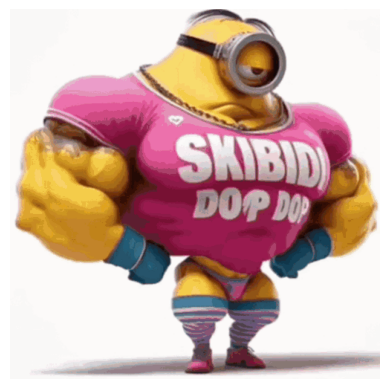

In [125]:
image_path = 'MINION.png'
color_image = cv2.imread(image_path)
color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
plt.imshow(color_image)
plt.axis('off')

# Размеры изображения

In [126]:
height, width, channels = color_image.shape
print(f"Размеры изображения: {width}x{height}, Каналы: {channels}")

Размеры изображения: 498x498, Каналы: 3


In [127]:
r_channel = color_image[:, :, 0]  # Красный канал
g_channel = color_image[:, :, 1]  # Зеленый канал
b_channel = color_image[:, :, 2]  # Синий канал

# Пространственные области изображения по отдельности

(np.float64(-0.5), np.float64(497.5), np.float64(497.5), np.float64(-0.5))

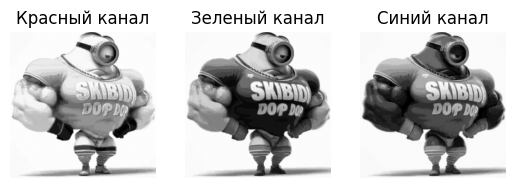

In [128]:
plt.subplot(2, 3, 1)
plt.imshow(r_channel, cmap='gray')
plt.title('Красный канал')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(g_channel, cmap='gray')
plt.title('Зеленый канал')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(b_channel, cmap='gray')
plt.title('Синий канал')
plt.axis('off')

# Парные комбинации пространственных областей изображения

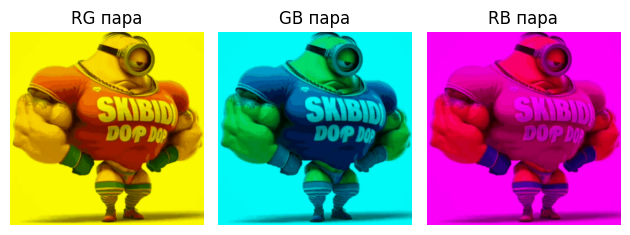

In [129]:
rg_pair = np.stack((r_channel, g_channel, np.zeros_like(r_channel)), axis=-1)
gb_pair = np.stack((np.zeros_like(g_channel), g_channel, b_channel), axis=-1)
rb_pair = np.stack((r_channel, np.zeros_like(b_channel), b_channel), axis=-1)

plt.subplot(2, 3, 4)
plt.imshow(rg_pair)
plt.title('RG пара')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(gb_pair)
plt.title('GB пара')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(rb_pair)
plt.title('RB пара')
plt.axis('off')

plt.tight_layout()
plt.show()

# Серое изображение

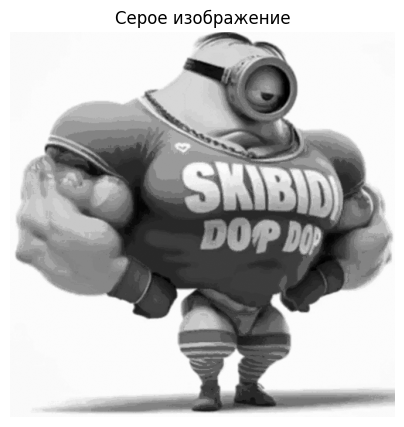

In [130]:
gray_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(5, 5))
plt.imshow(gray_image, cmap='gray')
plt.title('Серое изображение')
plt.axis('off')
plt.show()

In [131]:
gray_image

array([[248, 248, 248, ..., 250, 250, 250],
       [248, 248, 248, ..., 250, 250, 250],
       [248, 248, 248, ..., 250, 250, 250],
       ...,
       [248, 248, 248, ..., 248, 248, 248],
       [248, 248, 248, ..., 248, 248, 248],
       [248, 248, 248, ..., 248, 248, 248]], shape=(498, 498), dtype=uint8)

# Графики изменения частоты каналов

# Фурье...

Порядок действий:
      1) Прямое DCT (формула (1.4)-(1.7)):
         F(k,l) = (2/√(MN)) c(k)c(l) *
                  sum_{j=0..N-1}[ cos(πk/N·(j+1/2)) * (sum_{m=0..M-1} f(j,m) cos(πl/M·(m+1/2))) ].
      2) Усечение (частичные суммы): оставить только k=0..m, l=0..n, все остальные обнулить.
      3) Сглаживание Гиббса (формулы (1.15)-(1.17)):
         F_sm(k,l) = F(k,l) * exp(-a2 * λ_{k,l} * t), λ_{k,l} = (πk/N)^2 + (πl/M)^2.
      4) Обратное DCT/интерполяция (формула (1.6), но «N→H, M→W»):
         f̂(x,y) = (2/√(MN)) * sum_{k=0..m} sum_{l=0..n} [ c(k)c(l) F_sm(k,l) *
                     cos(πk/H·(x+1/2)) * cos(πl/W·(y+1/2)) ].

In [132]:
def resize_dct_raw(image, new_shape, keep_coeff=(None, None), smooth_t=0.0, a2=1 / 500000.0):
    """
    Увеличение изображения «в лоб» ровно по формулам ia.pdf.

    Порядок действий:
      1) Прямое DCT (формула (1.4)-(1.7)):
         F(k,l) = (2/√(MN)) c(k)c(l) * sum_{j=0..N-1} [
                   cos(πk/N·(j+1/2)) * (sum_{m=0..M-1} f(j,m) * cos(πl/M·(m+1/2))) ].
      2) Усечение (частичные суммы): оставить только k=0..m, l=0..n, все остальные обнулить.
      3) Сглаживание Гиббса (формулы (1.15)-(1.17)):
         F_sm(k,l) = F(k,l) * exp(-a2 * lm{k,l} * t), lm{k,l} = (πk/N)^2 + (πl/M)^2.
      4) Обратное DCT/интерполяция - формула (1.6)
         f̂(x,y) = (2/√(MN)) * sum_{k=0..m} sum_{l=0..n} [
          c(k)c(l) F_sm(k,l) * cos(πk/H*(x+1/2)) * cos(πl/W*(y+1/2)) ].
    """

    # 0) Приводим изображение к float.
    img = np.asarray(image, dtype=float)
    N, M = img.shape  # исходные размеры
    H, W = new_shape  # желаемые размеры (для интерполяции)

    # 1) Определяем функцию c(n) согласно (1.7):
    def c(n):
        return 1.0 / np.sqrt(2.0) if n == 0 else 1.0

    # 2) Выделяем память под полные DCT-коэффициенты F_full (размер N×M).
    F_full = np.zeros((N, M), dtype=float)

    # 2.1) Предвычислим нормирующий множитель
    norm = 2.0 / np.sqrt(N * M)

    # 2.2) Циклы по формуле (1.4)-(1.7):
    # Для каждого k=0..N-1 и l=0..M-1 нам нужно:
    #   F_full[k,l] = norm * c(k) * c(l) * S(k,l),
    #  где
    #   S(k,l) = sum_{j=0..N-1} [ cos(πk/N·(j+1/2)) * T(j,l) ],
    #   T(j,l) = sum_{m=0..M-1} [ f(j,m) * cos(πl/M * (m+1/2)) ].
    for k in range(N):
        ck = c(k)
        for l in range(M):
            cl = c(l)
            S_k_l = 0.0
            for j in range(N):
                T_j_l = 0.0
                cos_j_factor = np.cos(np.pi * k * (j + 0.5) / N)
                for m in range(M):
                    cos_m_factor = np.cos(np.pi * l * (m + 0.5) / M)
                    T_j_l += img[j, m] * cos_m_factor
                S_k_l += cos_j_factor * T_j_l
            F_full[k, l] = norm * ck * cl * S_k_l

    # 3) Усечение (частичная сумма) по keep_coeff = (m, n).
    # Если keep_coeff = (None,None), значит m=N-1, n=M-1 (все коэффициенты).
    if keep_coeff[0] is None or keep_coeff[1] is None:
        m, n = N - 1, M - 1
    else:
        m, n = keep_coeff
        if not (0 <= m < N and 0 <= n < M):
            raise ValueError("keep_coeff должно удовлетворять 0 ≤ m < N, 0 ≤ n < M")

    F_cut = np.zeros_like(F_full)
    F_cut[:m + 1, :n + 1] = F_full[:m + 1, :n + 1]

    # 4) Сглаживание (эффект Гиббса) по формулам (1.15)-(1.17):
    #  lm{k,l} = (π k / N)^2 + (π l / M)^2.
    #  Если smooth_t > 0, то F_cut[k,l] *= exp(-a2 * lm{k,l} * smooth_t).
    if smooth_t > 0.0:
        for k in range(m + 1):
            for l in range(n + 1):
                lam = (np.pi * k / N) ** 2 + (np.pi * l / M) ** 2
                F_cut[k, l] *= np.exp(-a2 * lam * smooth_t)

    # 5) Обратная формула (1.6) для интерполяции (IDCT):
    # Мы хотим восстановить отсечённые коэффициенты F_cut[k,l] в точках (x,y),
    # где x = 0..H-1, y = 0..W-1. Тогда формула (1.6) становится:
    #      f(x,y) = (2/√(MN)) *
    #                sum_{k=0..m} sum_{l=0..n} [
    #                  c(k) * c(l) * F_cut[k,l]
    #                  * cos( πk/H * (x + 1/2) )
    #                  * cos( πl/W * (y + 1/2) )
    #                ].

    resized = np.zeros((H, W), dtype=float)
    inv_norm = 2.0 / np.sqrt(N * M)
    for x in range(H):
        for y in range(W):
            sum_val = 0.0
            for k in range(m + 1):
                ck = c(k)
                cos_k_factor = np.cos(np.pi * k * (x + 0.5) / H)
                for l in range(n + 1):
                    cl = c(l)
                    cos_l_factor = np.cos(np.pi * l * (y + 0.5) / W)
                    sum_val += ck * cl * F_cut[k, l] * cos_k_factor * cos_l_factor
            resized[x, y] = inv_norm * sum_val

    return resized

In [133]:
def resize_dct_fast(image, new_shape, keep_coeff=(None, None), smooth_t=0.0, a2=1 / 500000.0):
    """
    Оптимизированная версия по формулам из ia.pdf:

      • Шаг 2 (прямой DCT):
        – Таблицы cos_m_table (M×M) и cos_j_table (N×N).
        – Две матричные операции: T = img * cos_m_table,  B = cos_j_table.T * T.
        – Broadcast: F_full = norm * (c_k[:,None] * B * c_l[None,:]).
      • Шаг 3 (усечение): F_cut = F_full[:m+1,:n+1].
      • Шаг 4 (сглаживание): in-place broadcast exp(−a2·lm·t) вместо вложенных циклов.
      • Шаг 5 (обратный DCT):
        – Таблицы cos_k_table (H×(m+1)) и cos_l_table (W×(n+1)), умноженные на c_k, c_l.
        – Одна матричная операция: resized = inv_norm * (D_H · F_sub · D_Wᵀ).
    """
    # 0) Приведение input к float
    img = np.asarray(image, dtype=float)
    N, M = img.shape
    H, W = new_shape

    # 1) Предвычисляем векторы c_k и c_l формула (1.7)
    c_k = np.ones(N, dtype=float)
    c_k[0] = 1.0 / np.sqrt(2.0)
    c_l = np.ones(M, dtype=float)
    c_l[0] = 1.0 / np.sqrt(2.0)

    # 2.1) cos_m_table: cos(πl*(m+1/2)/M)
    m_idx = np.arange(M)
    l_idx = np.arange(M)
    angles_M = np.pi * np.outer(m_idx + 0.5, l_idx) / M
    cos_m_table = np.cos(angles_M)

    # 2.2) cos_j_table: cos(πk*(j+1/2)/N)
    j_idx = np.arange(N)
    k_idx = np.arange(N)
    angles_N = np.pi * np.outer(j_idx + 0.5, k_idx) / N
    cos_j_table = np.cos(angles_N)

    # 2.3) Прямой DCT:
    T = img.dot(cos_m_table)
    B = cos_j_table.T.dot(T)
    norm = 2.0 / np.sqrt(N * M)
    # 2.4) Broadcast вместо двойного цикла (k,l):
    F_full = norm * (c_k[:, None] * B * c_l[None, :])  # (N×M)

    # 3) Усечение (частичная сумма):
    if keep_coeff[0] is None or keep_coeff[1] is None:
        m, n = N - 1, M - 1
    else:
        m, n = keep_coeff
        if not (0 <= m < N and 0 <= n < M):
            raise ValueError("keep_coeff должно удовлетворять 0 ≤ m < N, 0 ≤ n < M")

    F_cut = np.zeros_like(F_full)
    F_cut[:m + 1, :n + 1] = F_full[:m + 1, :n + 1]

    # 4) Сглаживание - эффект Гиббса.
    if smooth_t > 0.0:
        for k in range(m + 1):
            for l in range(n + 1):
                lam = (np.pi * k / N) ** 2 + (np.pi * l / M) ** 2
                F_cut[k, l] *= np.exp(-a2 * lam * smooth_t)

    # 5.1) cos_k_table (H×(m+1)): cos(π*k*(x+1/2)/H)*c(k)
    x_idx = np.arange(H)
    k_idx_trunc = np.arange(m + 1)
    angles_H = np.pi * np.outer(x_idx + 0.5, k_idx_trunc)
    cos_k_table = np.cos(angles_H)
    D_H = cos_k_table * c_k[k_idx_trunc][None, :]

    # 5.2) cos_l_table (W×(n+1)): cos(π*l*(y+1/2)/W)*c(l)
    y_idx = np.arange(W)
    l_idx_trunc = np.arange(n + 1)
    angles_W = np.pi * np.outer(y_idx + 0.5, l_idx_trunc) / W
    cos_l_table = np.cos(angles_W)
    D_W = cos_l_table * c_l[l_idx_trunc][None, :]

    # 5.3) Обратный DCT
    F_sub = F_cut[:m + 1, :n + 1]

    # 5.4) Собираем финальное resized (H×W)
    inv_norm = 2.0 / np.sqrt(N * M)
    resized = inv_norm * (D_H.dot(F_sub).dot(D_W.T))  # (H, W)

    return resized


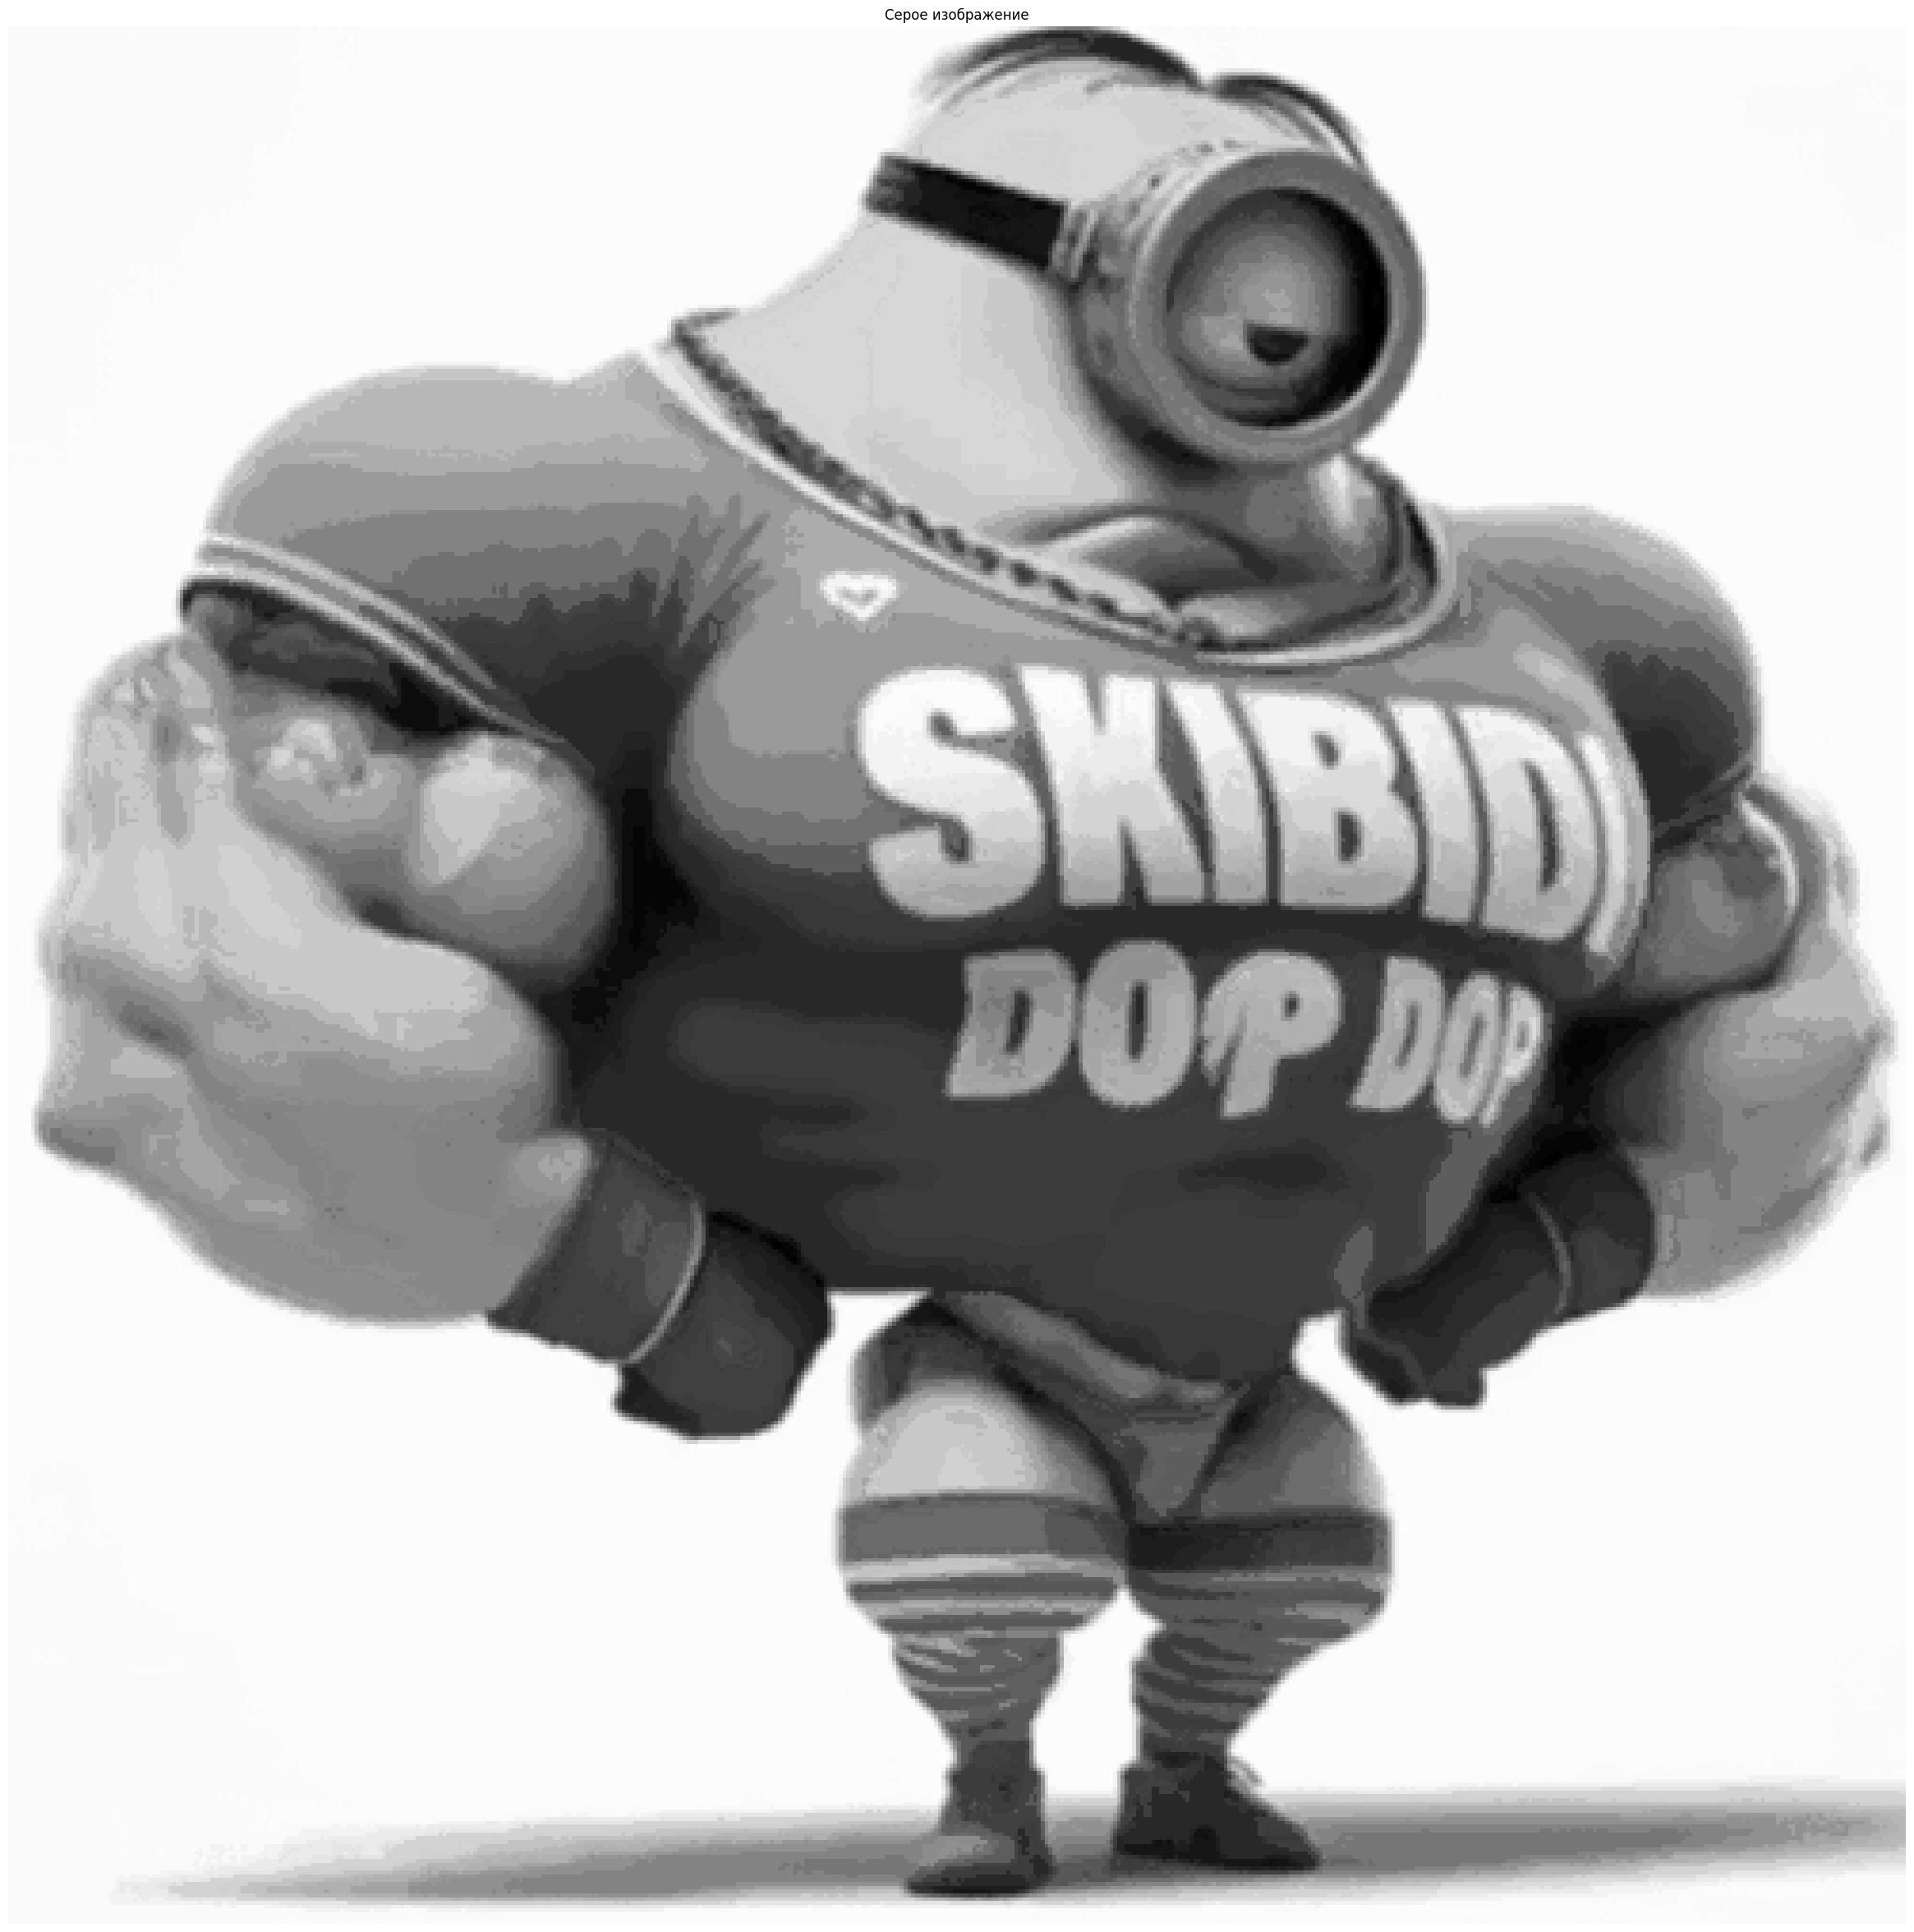

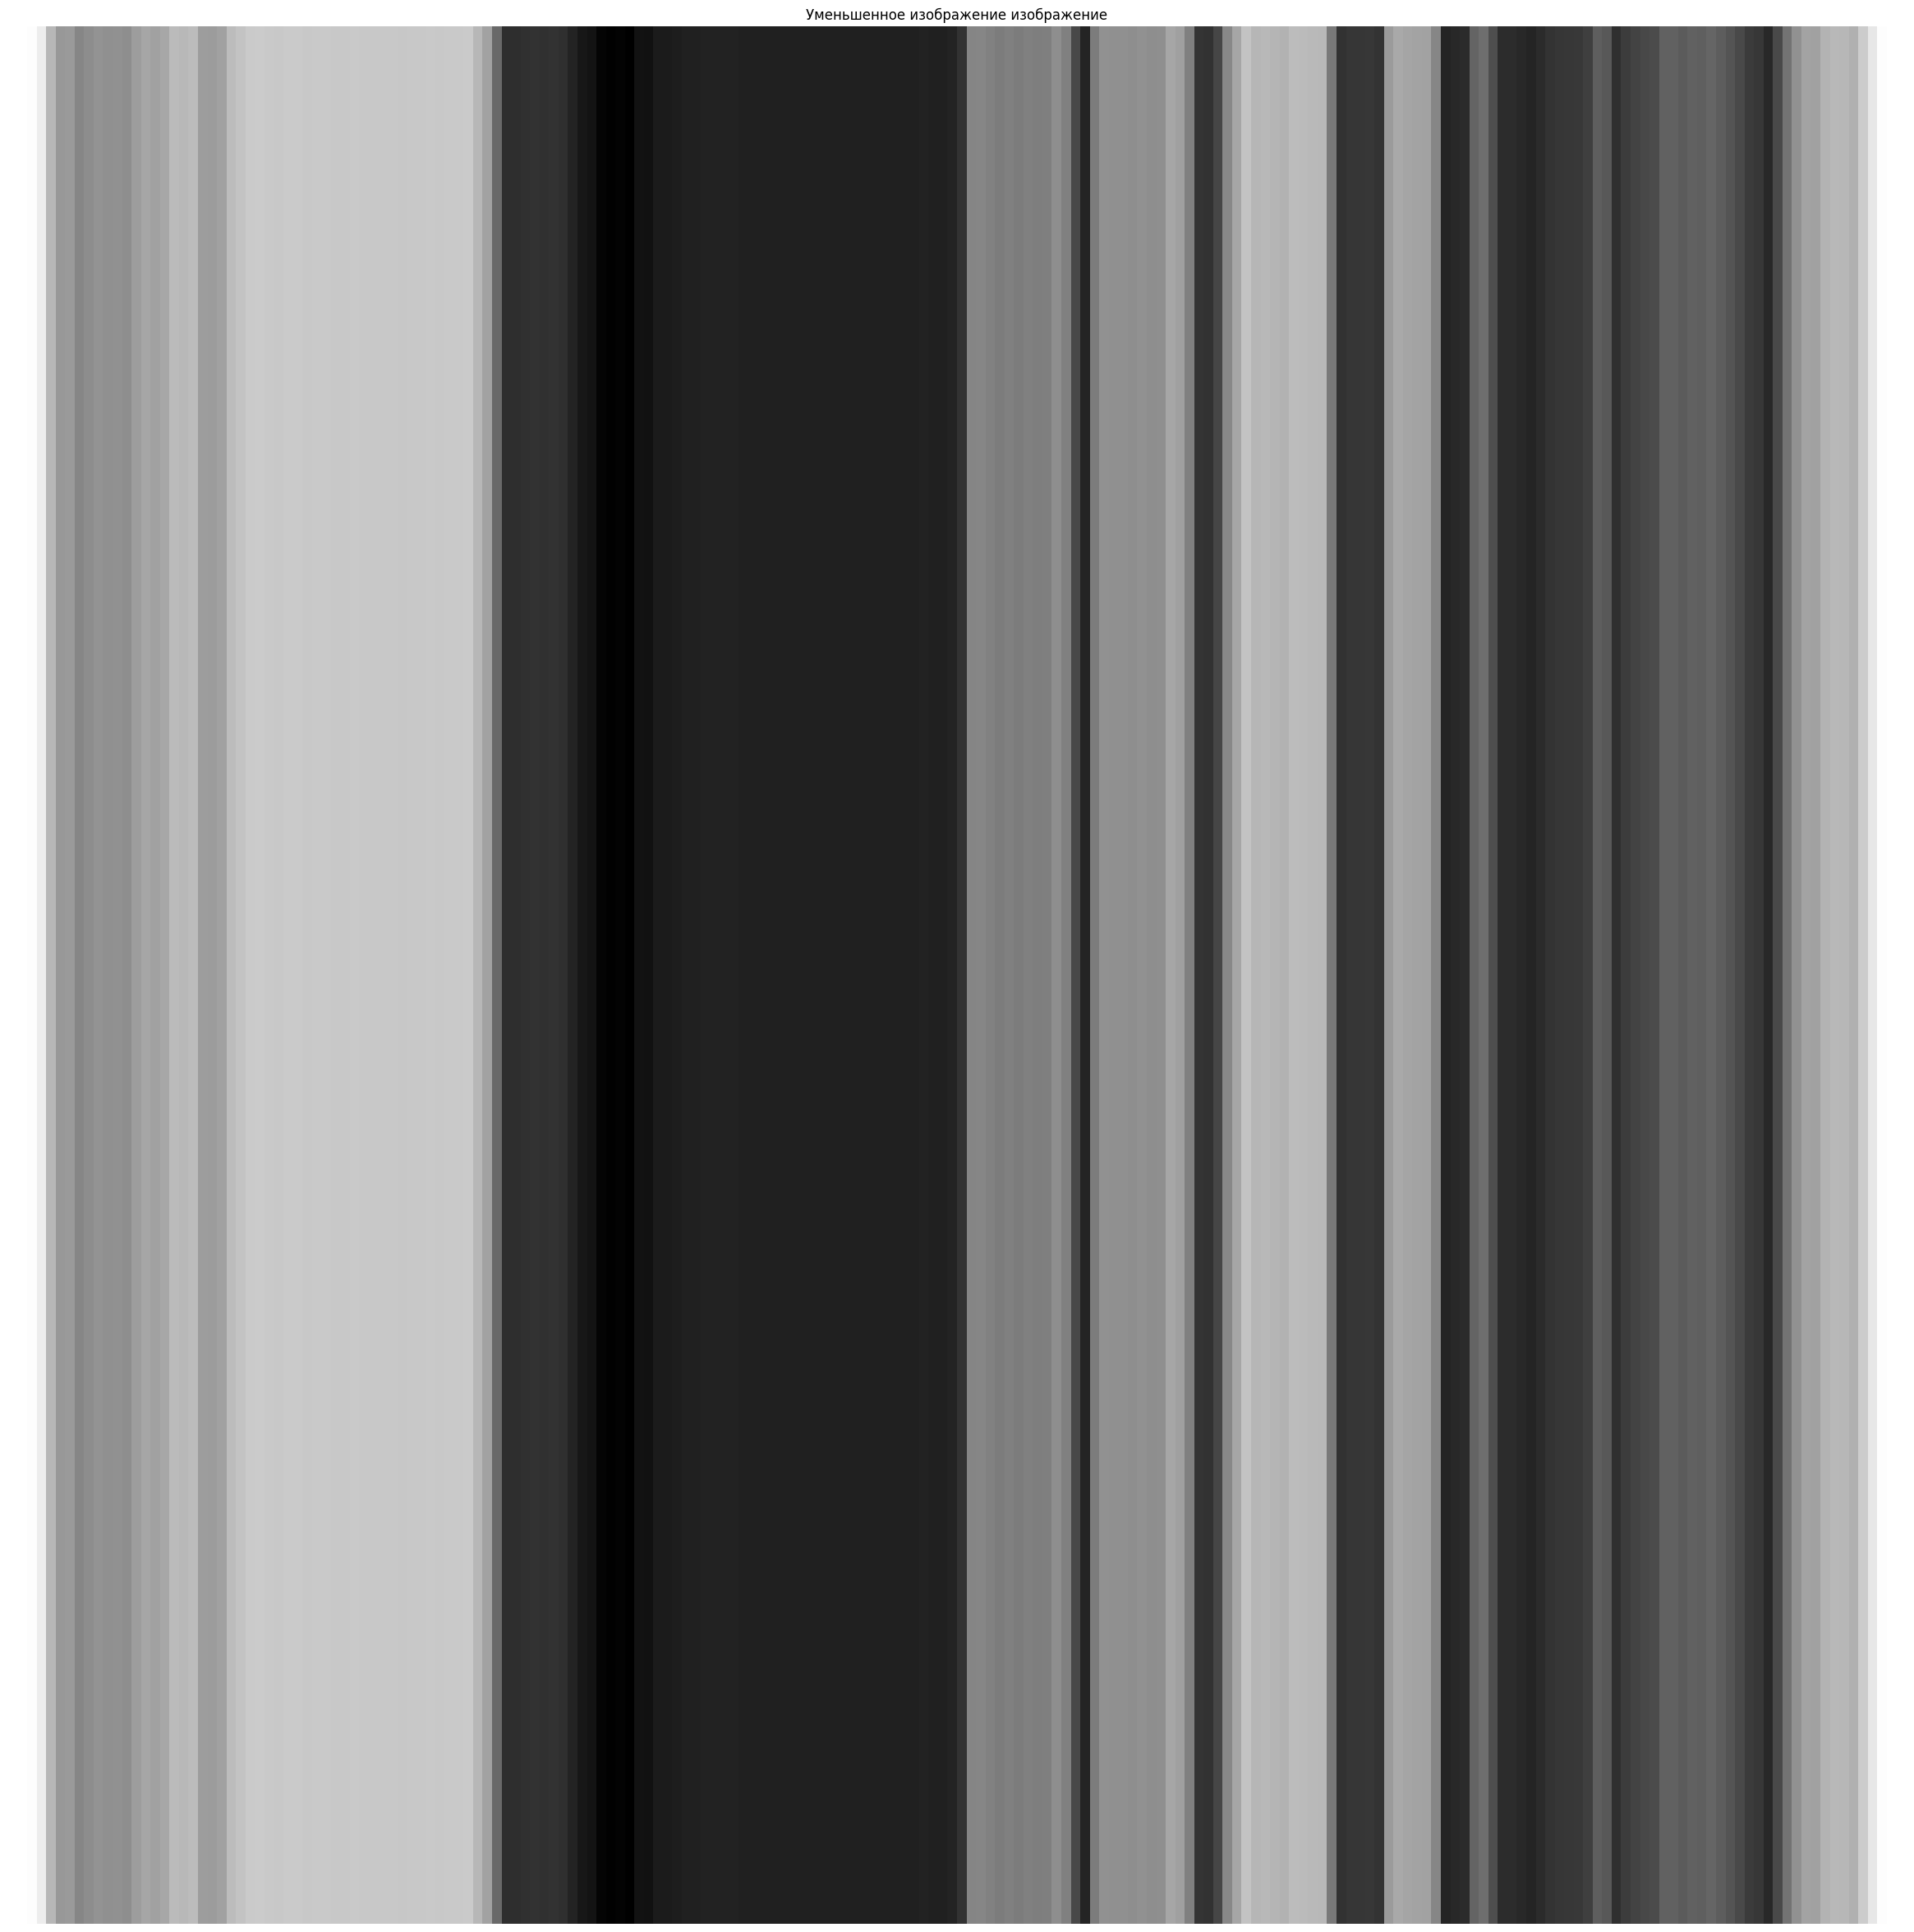

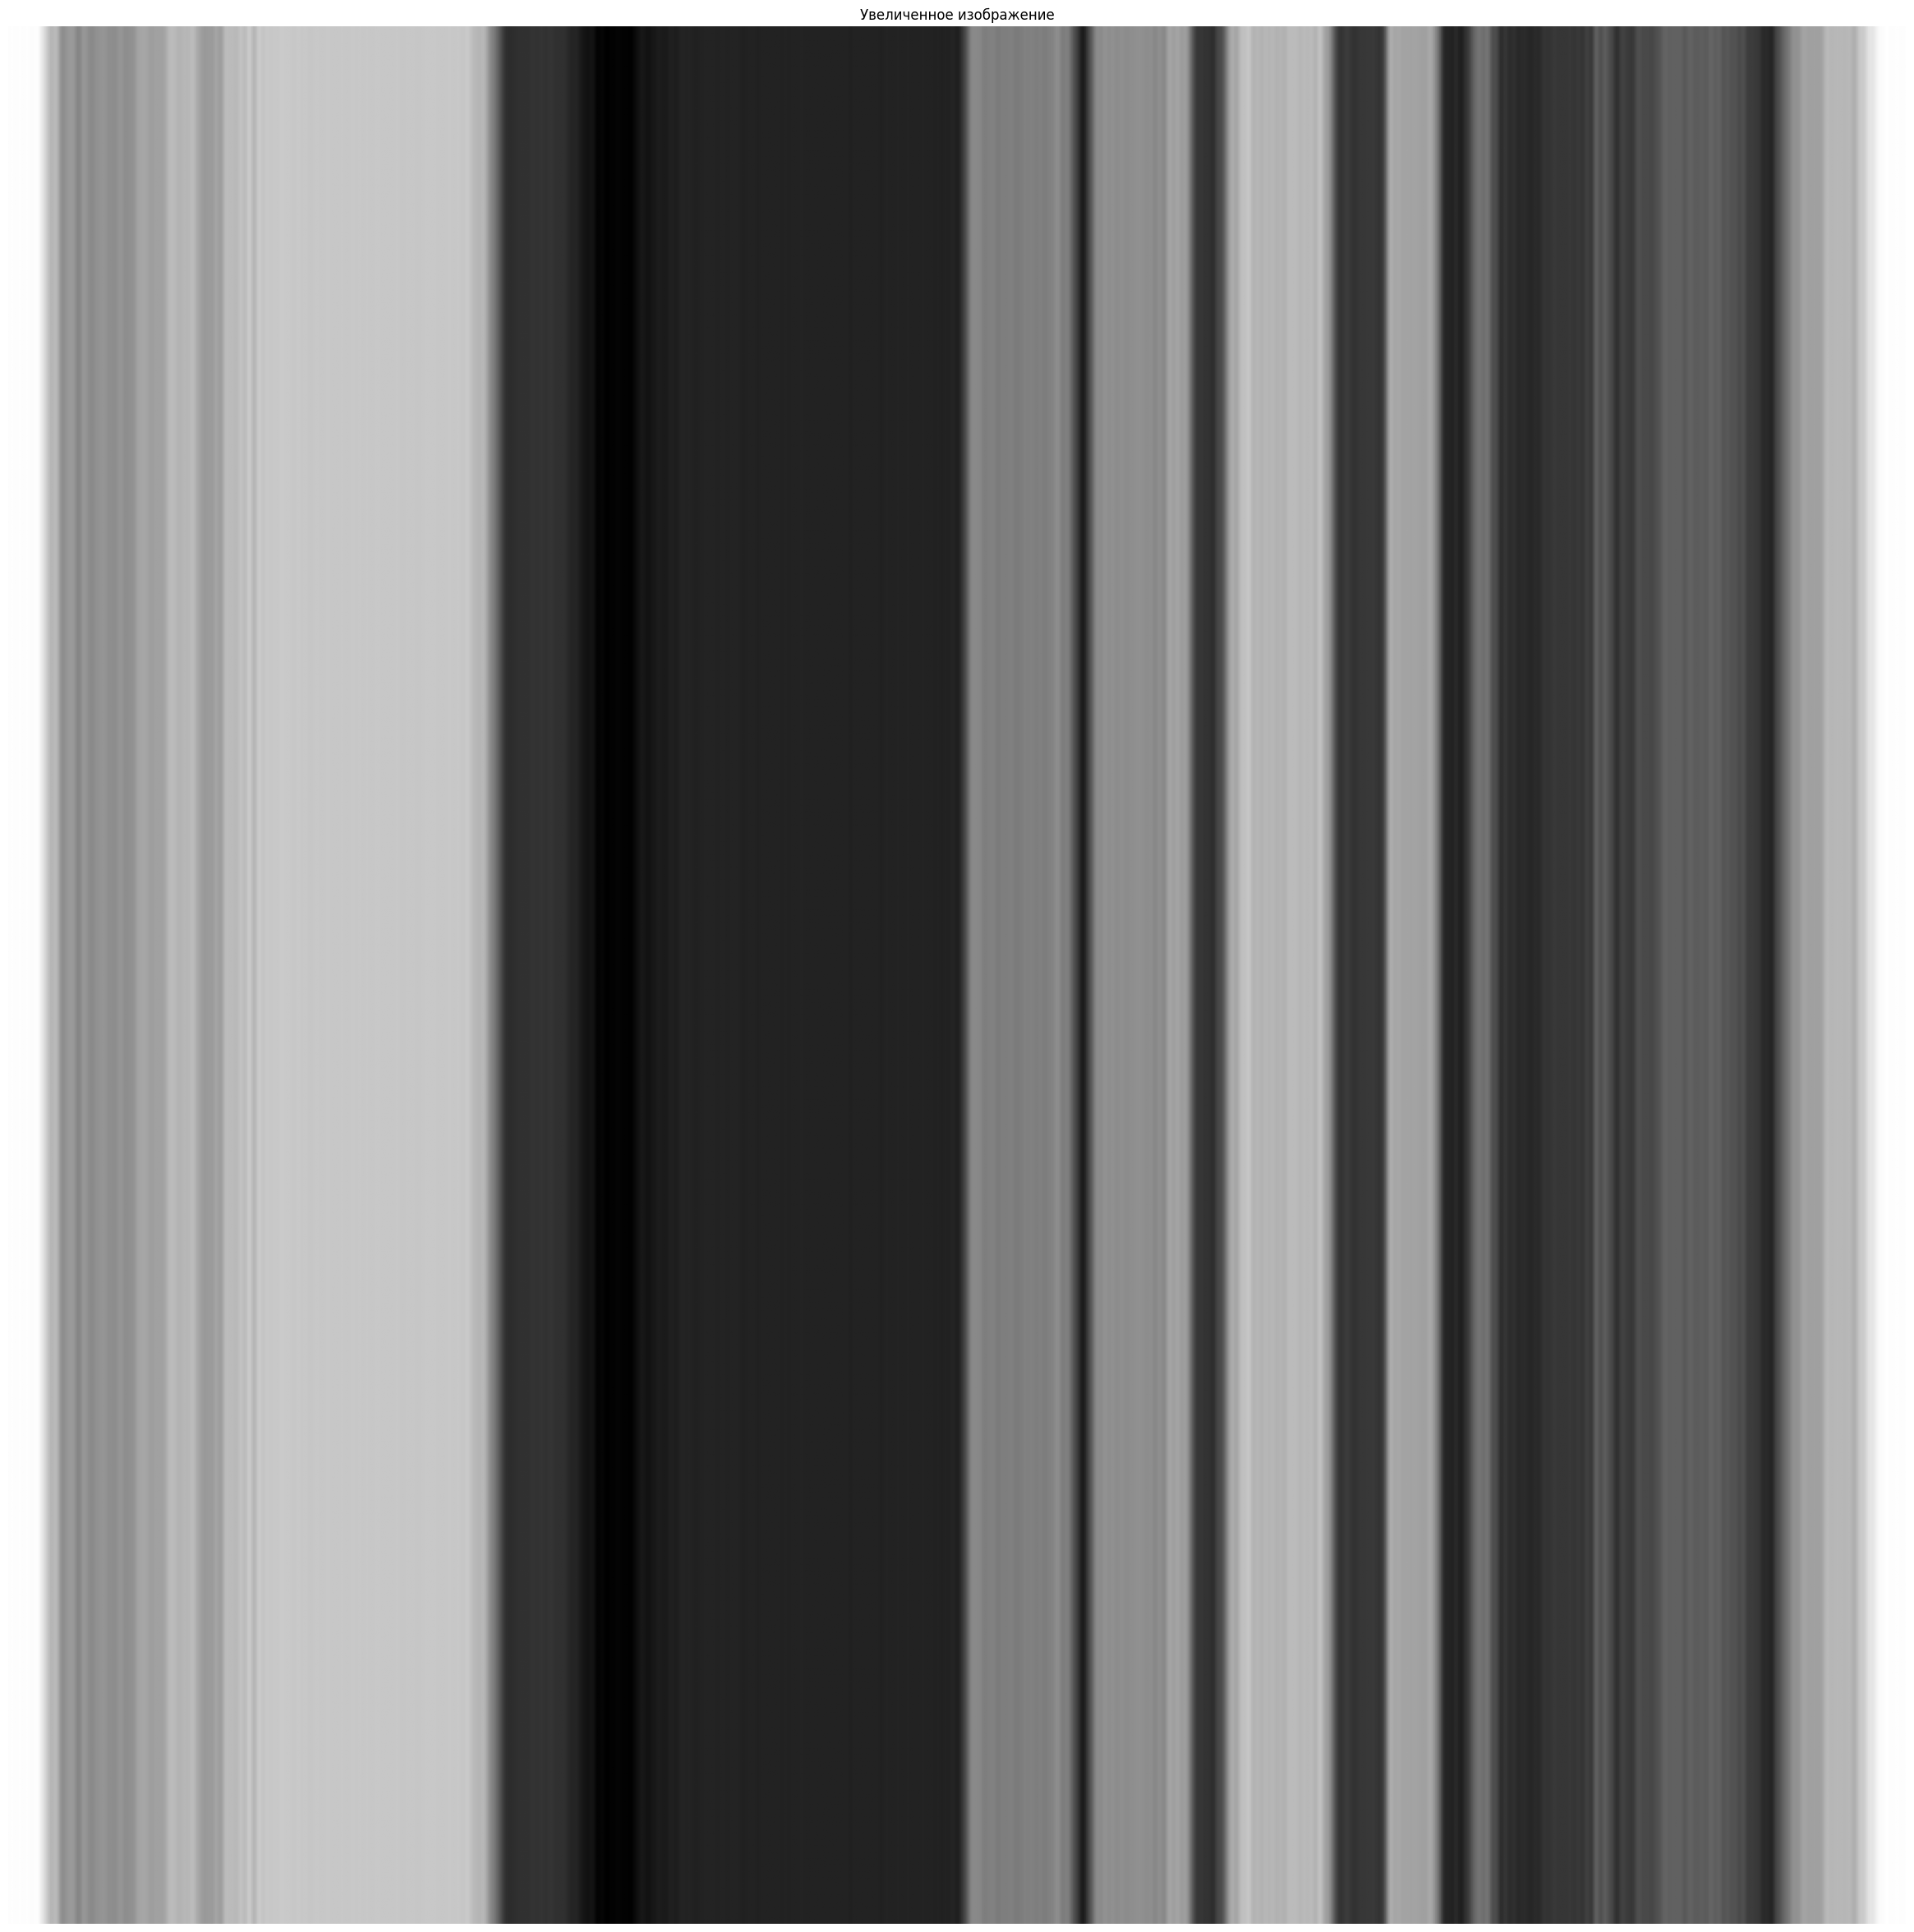

In [134]:
plt.figure(figsize=(30, 30))
plt.imshow(gray_image, cmap='gray')
plt.title('Серое изображение')
plt.axis('off')
plt.show()

plt.figure(figsize=(30, 30))
plt.imshow(resize_dct_fast(gray_image, new_shape=(200, 200)), cmap='gray')
plt.title('Уменьшенное изображение изображение')
plt.axis('off')
plt.show()
plt.figure(figsize=(30, 30))
plt.imshow(resize_dct_fast(gray_image, new_shape=(1000, 1000)), cmap='gray')
plt.title('Увеличенное изображение')
plt.axis('off')
plt.show()

In [135]:
def resize_dct_color(image_rgb, new_shape, keep_coeff=(None, None), smooth_t=0.0, a2=1 / 500000.0):
    """
    Применяет DCT-масштабирование к цветному изображению (RGB).
    Просто обрабатывает каждый канал независимо.
    """

    # Если изображение не трёхканальное — выдать ошибку
    if image_rgb.ndim != 3 or image_rgb.shape[2] != 3:
        raise ValueError("Ожидается цветное изображение RGB с формой (H, W, 3)")

    out_channels = []
    for ch in range(3):
        channel = image_rgb[:, :, ch]
        resized_channel = resize_dct_fast(
            channel,
            new_shape,
            keep_coeff=keep_coeff,
            smooth_t=smooth_t,
            a2=a2
        )
        out_channels.append(resized_channel)

    # Собираем 3 канала обратно
    result = np.stack(out_channels, axis=2)

    # Обрезаем диапазон и преобразуем в uint8
    return np.clip(result, 0, 255).astype(np.uint8)


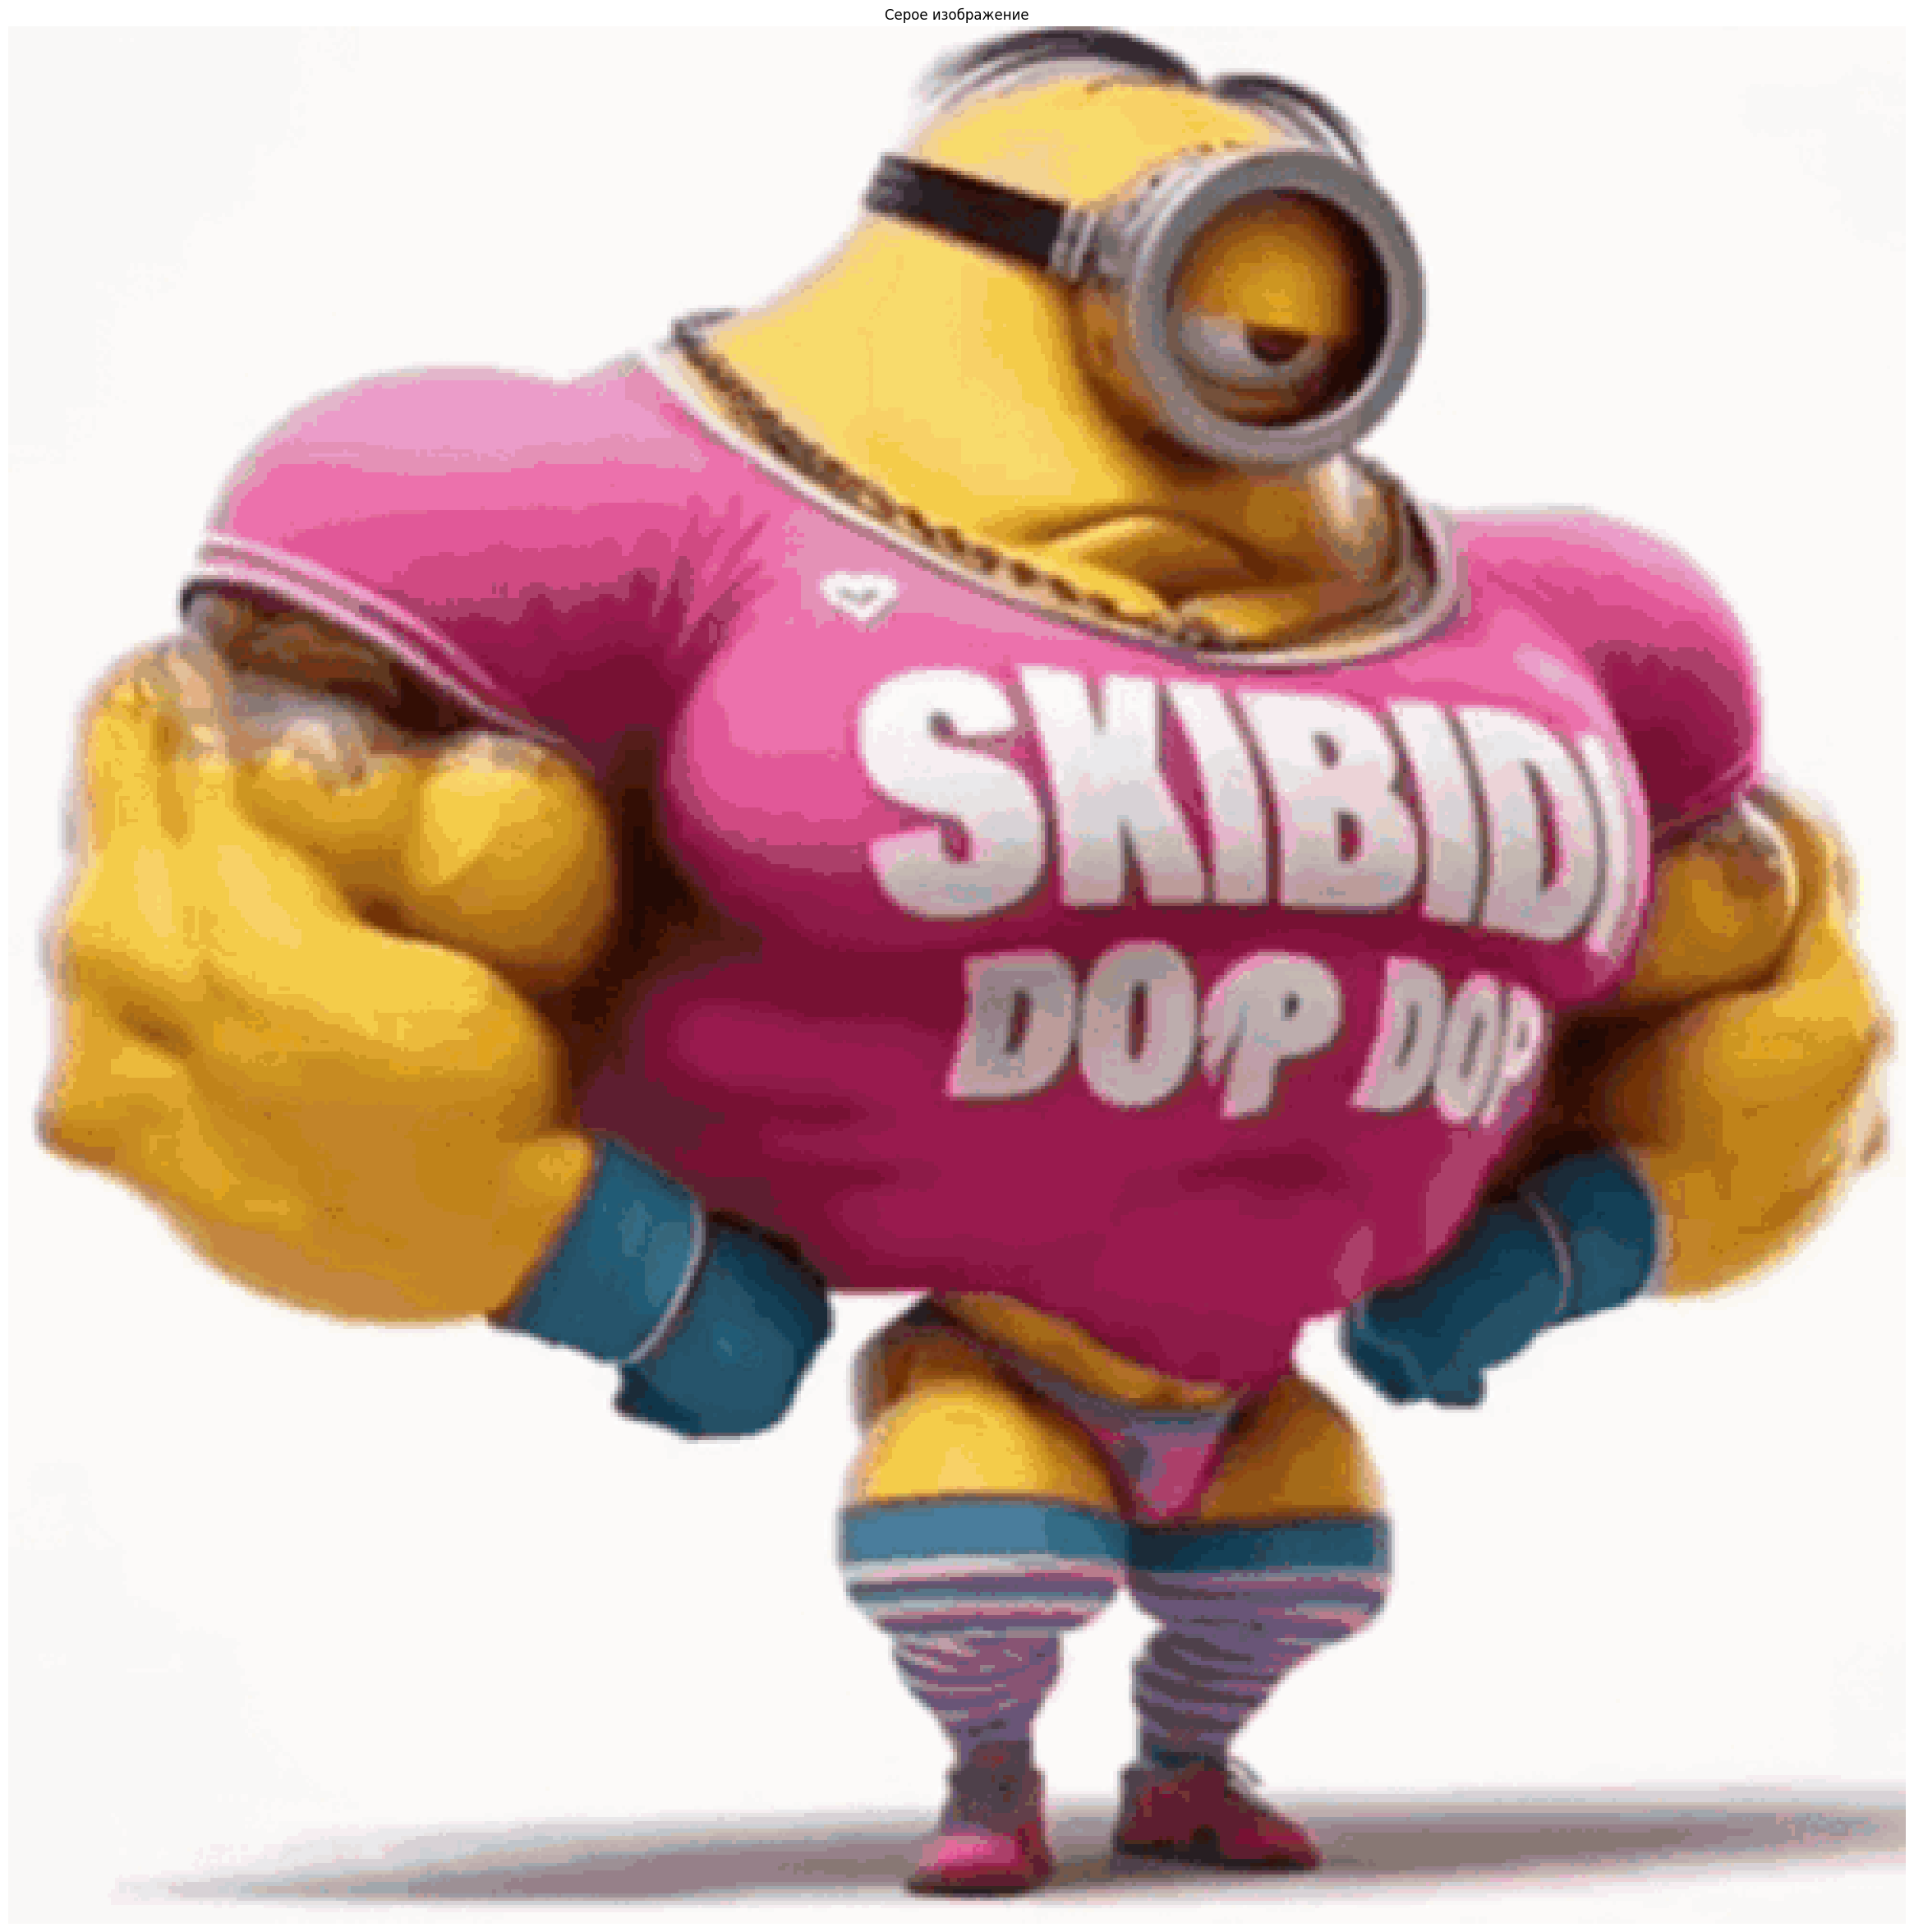

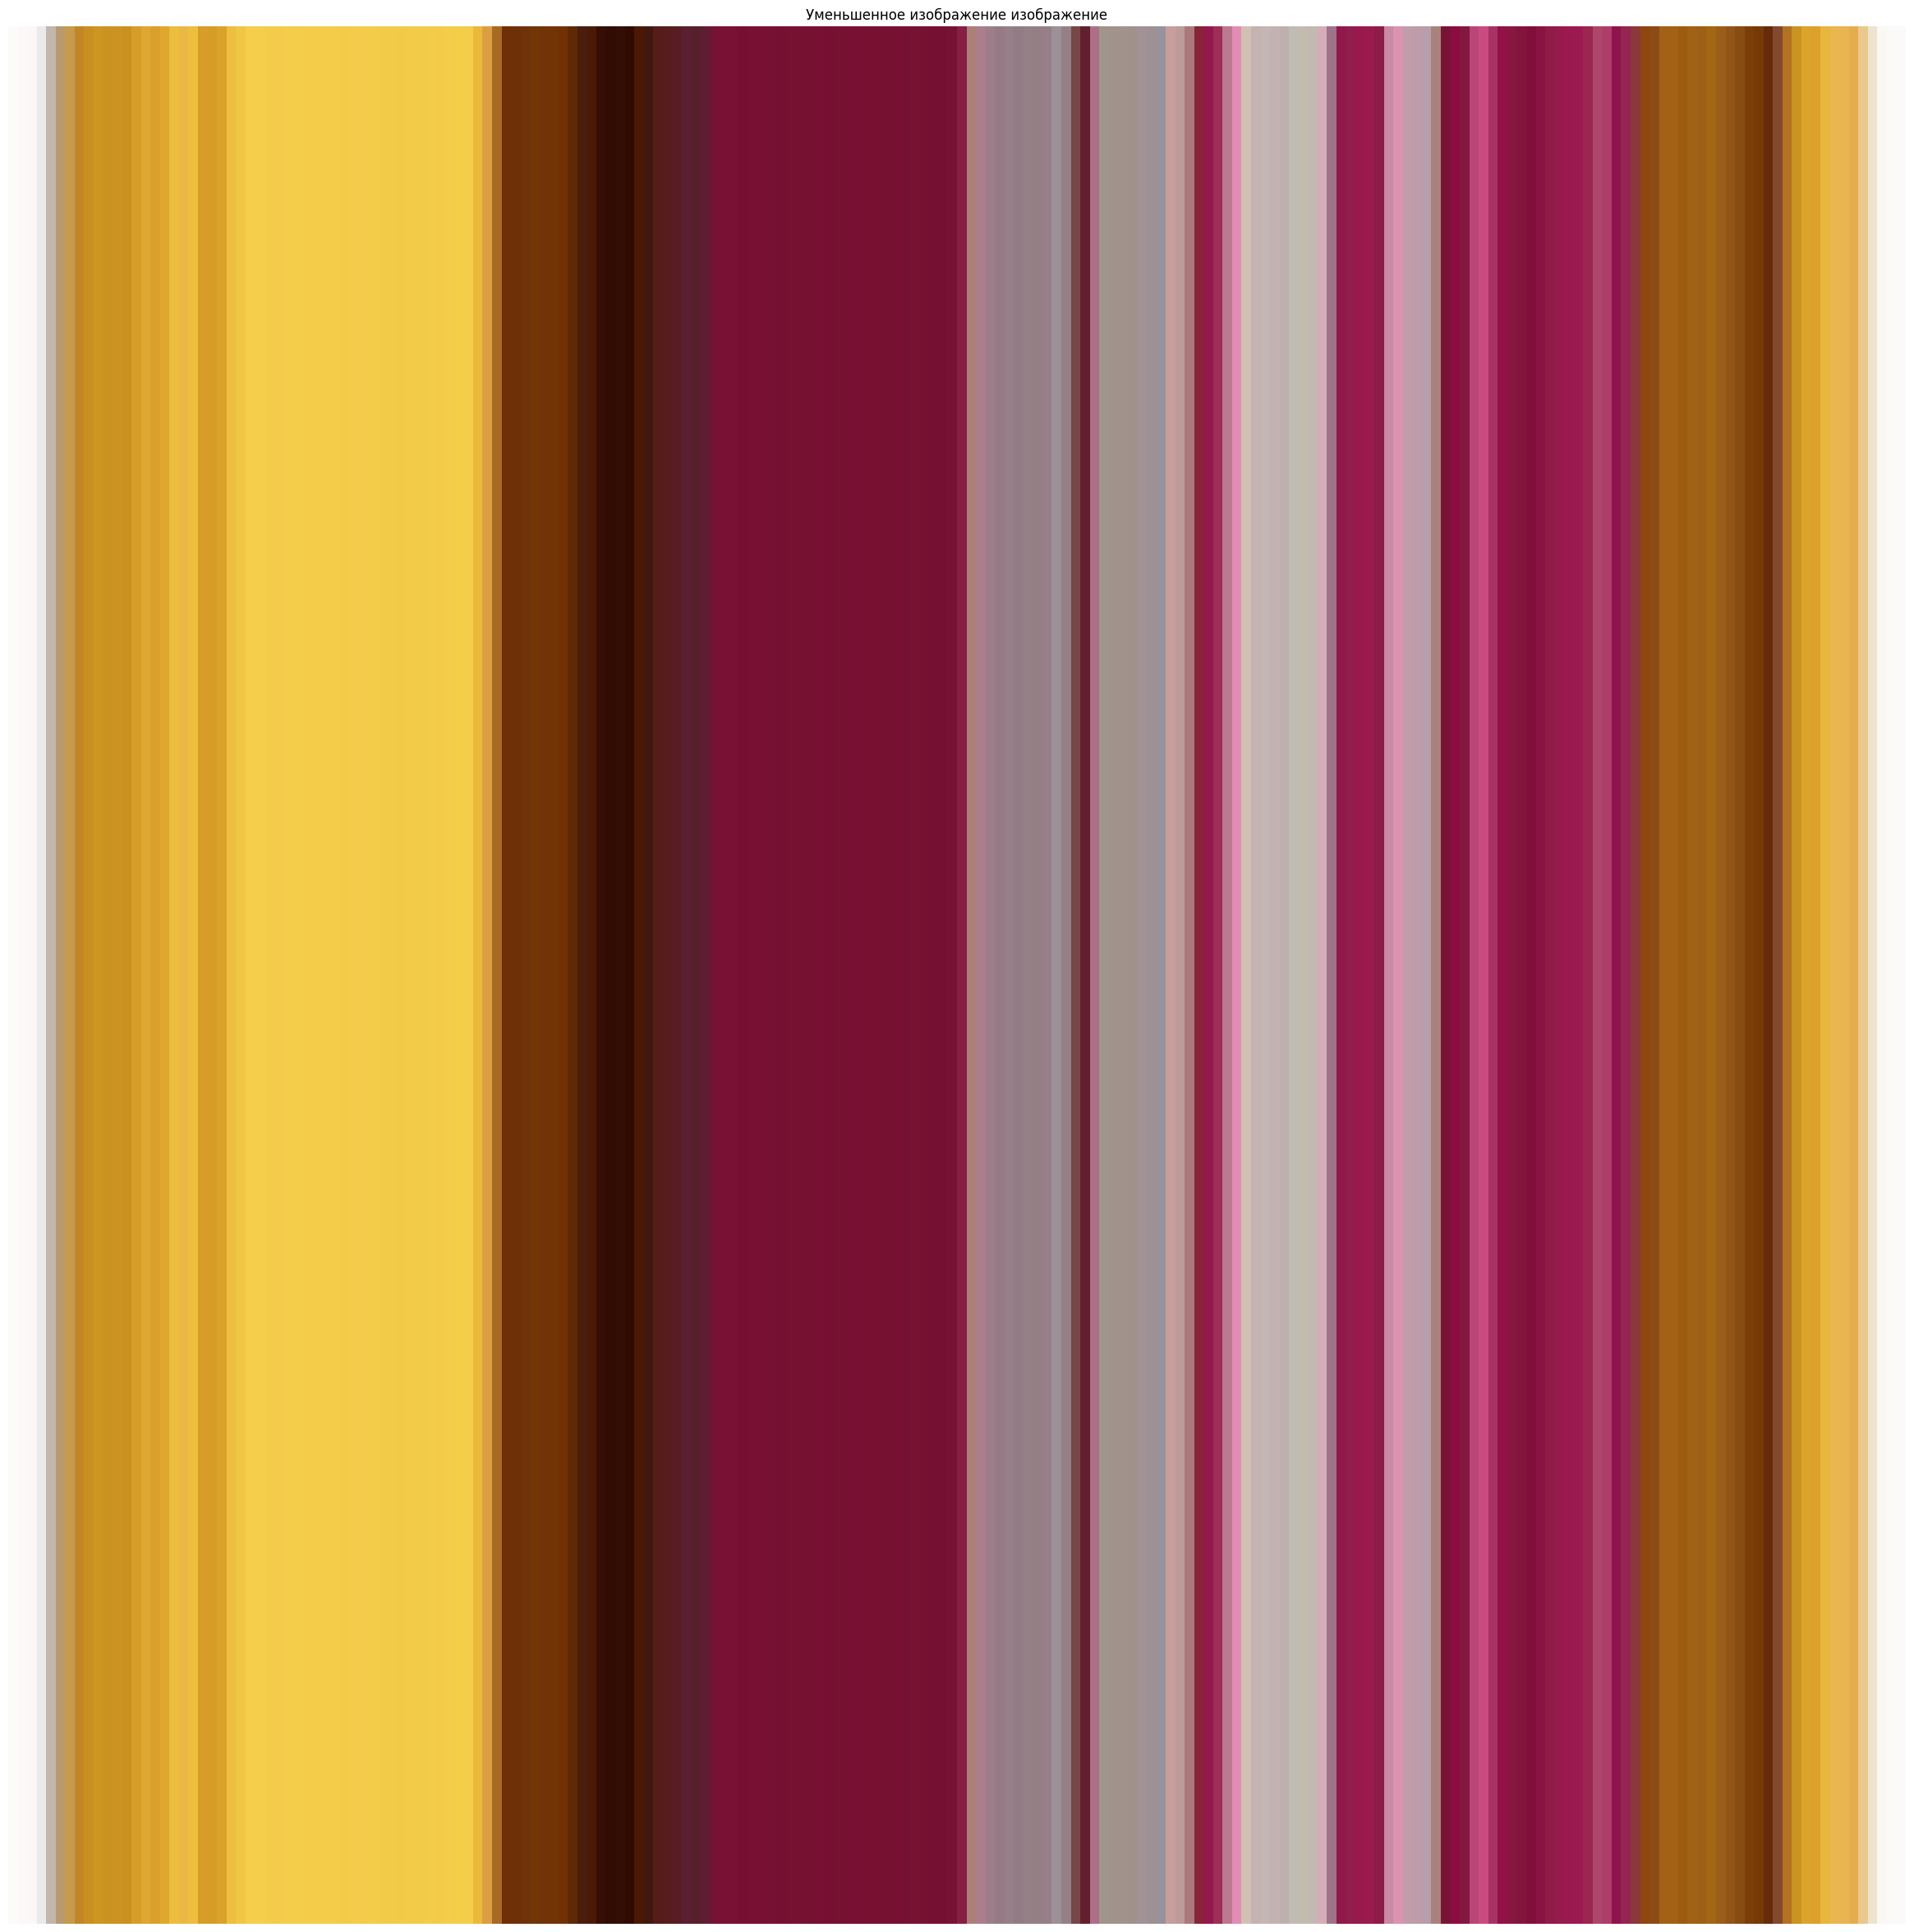

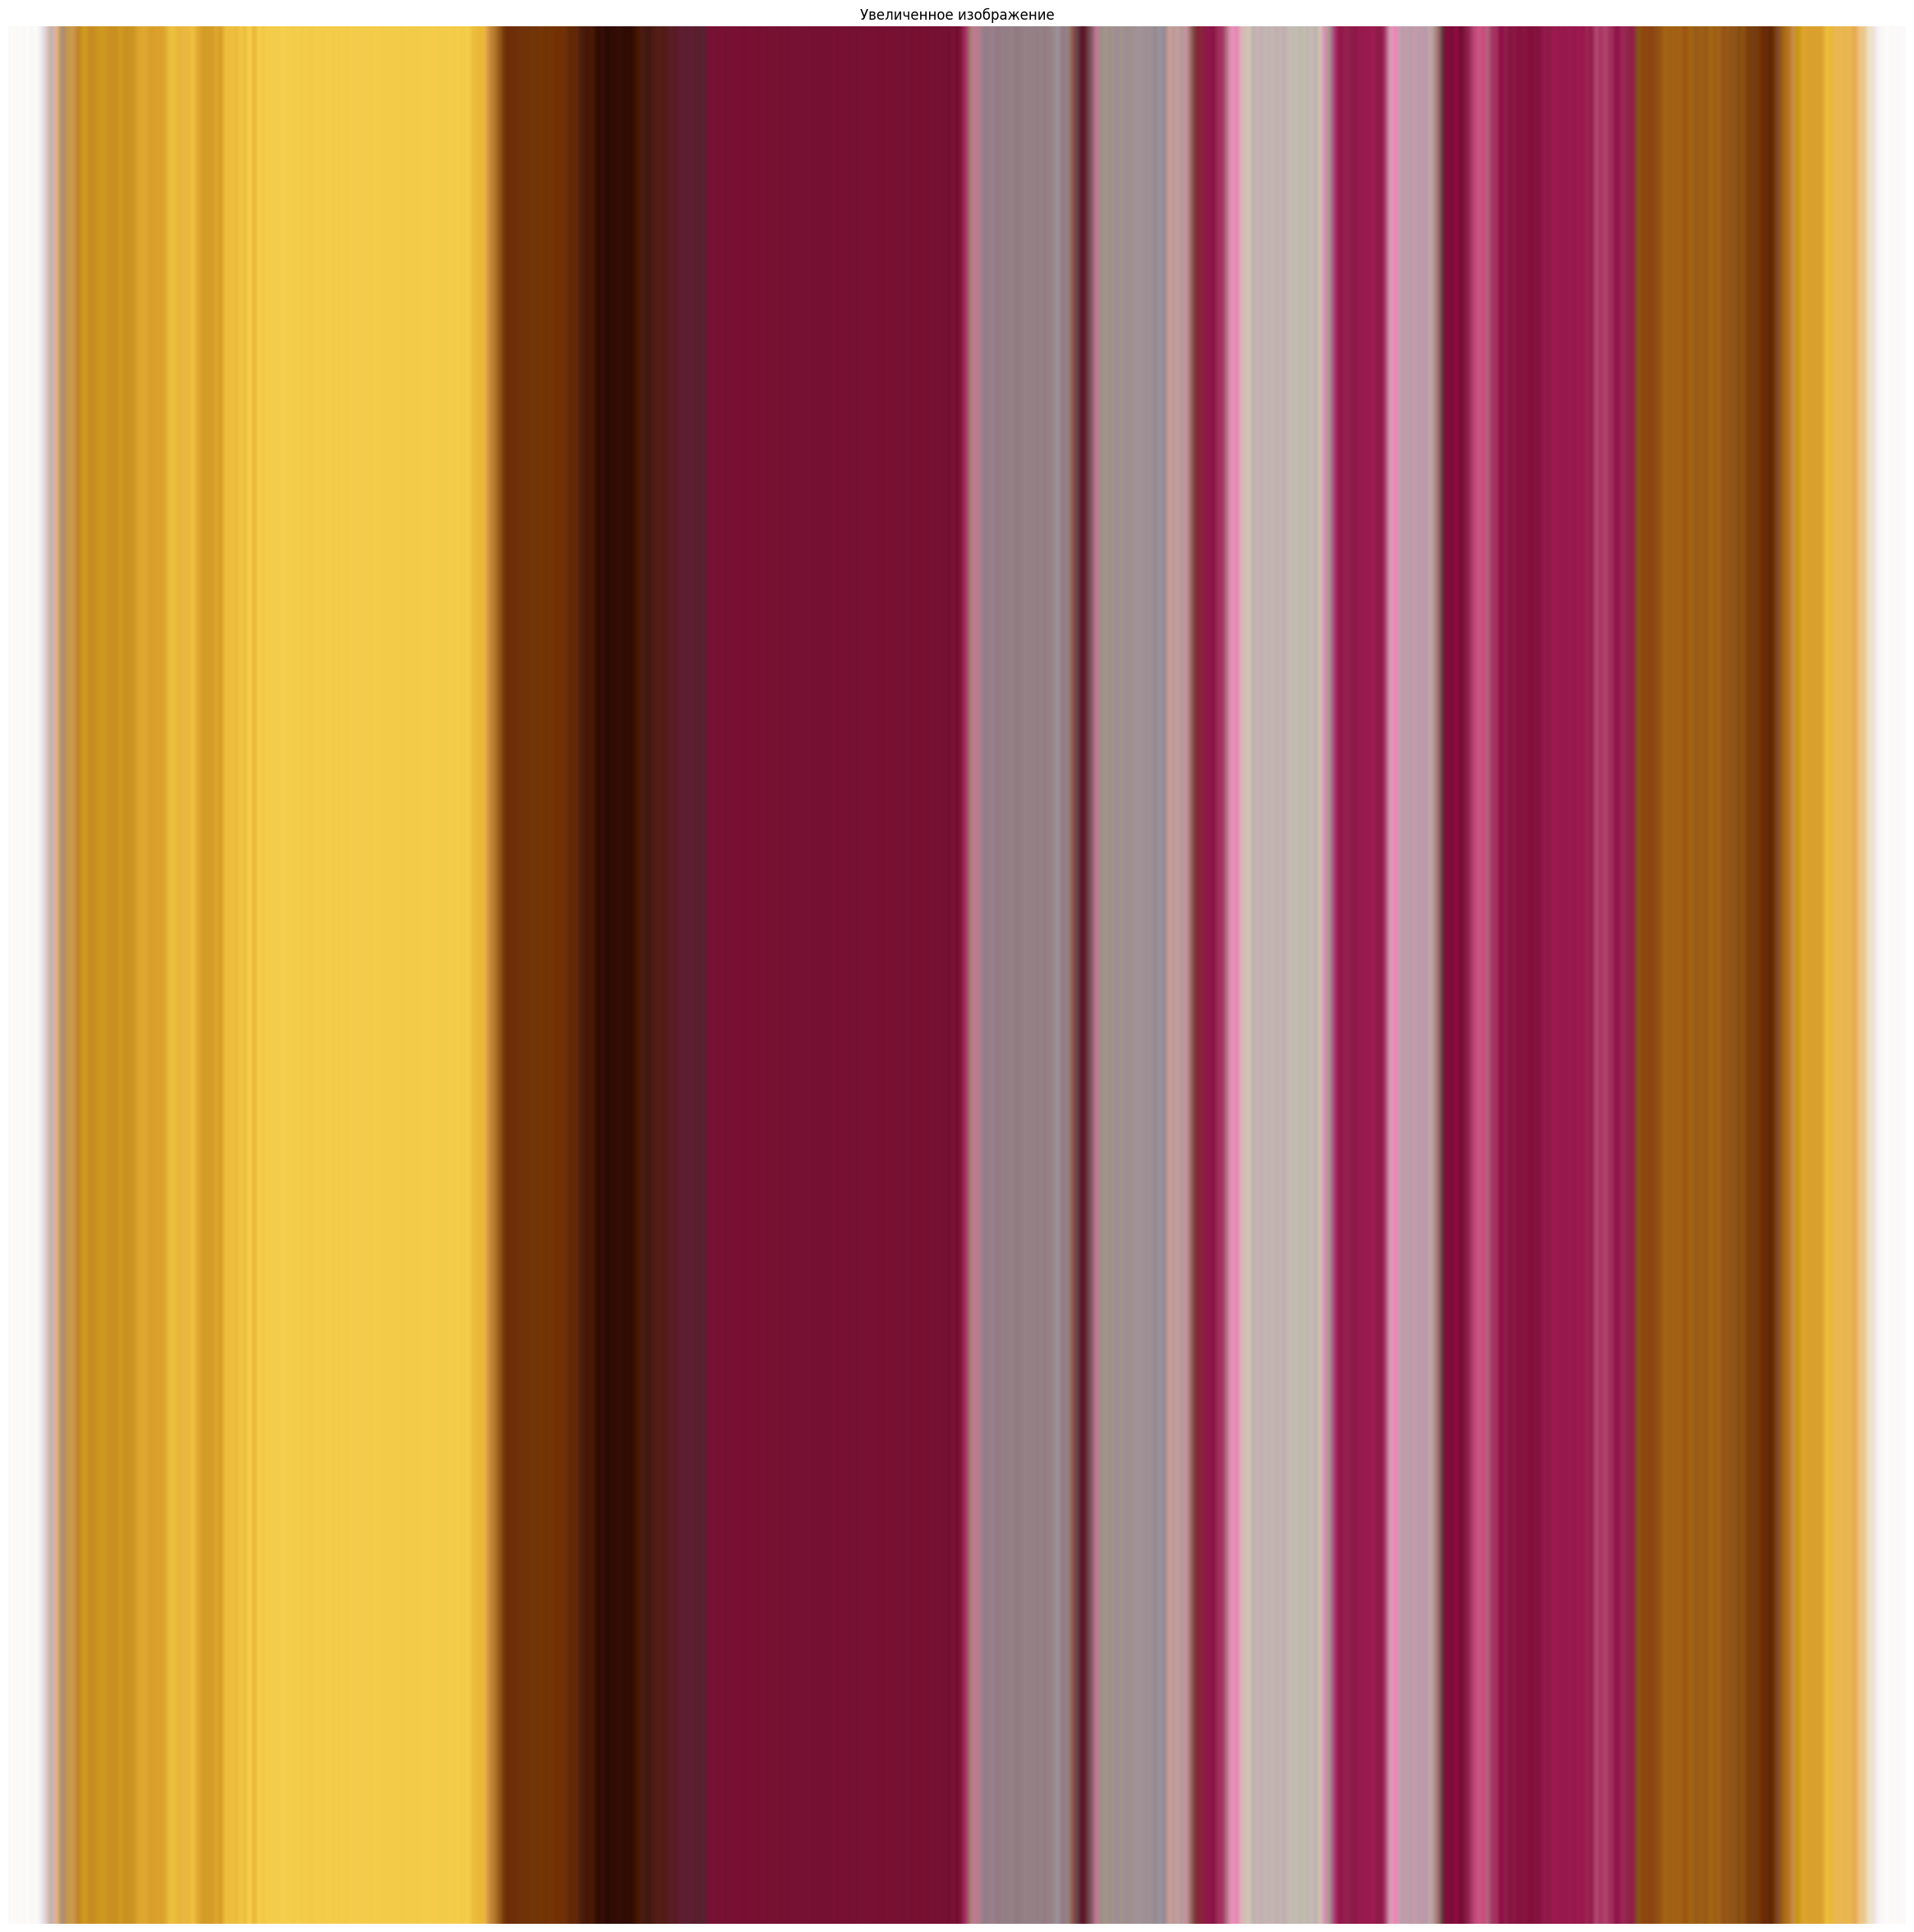

In [136]:
plt.figure(figsize=(30, 30))
plt.imshow(color_image)
plt.title('Серое изображение')
plt.axis('off')
plt.show()

plt.figure(figsize=(30, 30))
plt.imshow(resize_dct_color(color_image, new_shape=(200, 200)))
plt.title('Уменьшенное изображение изображение')
plt.axis('off')
plt.show()
plt.figure(figsize=(30, 30))
plt.imshow(resize_dct_color(color_image, new_shape=(1000, 1000)))
plt.title('Увеличенное изображение')
plt.axis('off')
plt.show()

In [137]:
# Cooley-Tukey
# формулы (1.8-1.13)

def fft1d(x):
    N = len(x)
    if N <= 1:
        return x

    # Разделение по чётным/нечётным
    even = fft1d(x[::2])
    odd = fft1d(x[1::2])

    # Формула БПФ: exp(-2πik/N) * odd
    W = [np.exp(-2j * np.pi * k / N) * odd[k] for k in range(N // 2)]

    # Сборка итоговой последовательности из even и odd
    return [even[k] + W[k] for k in range(N // 2)] + [even[k] - W[k] for k in range(N // 2)]


def ifft1d(X):
    N = len(X)
    if N <= 1:
        return X

    # Формула для ОБПФ: conj(FFT(conj(x))) / N
    X_conj = np.conjugate(X)
    fft_conj = fft1d(X_conj)
    return [np.conjugate(val) / N for val in fft_conj]

In [138]:
def fft2d(img):
    # Приводим размер изображения к степени 2ки
    h = 2 ** np.ceil(np.log2(img.shape[0])).astype(int)
    w = 2 ** np.ceil(np.log2(img.shape[1])).astype(int)
    padded_img = np.pad(img, ((0, h - img.shape[0]), (0, w - img.shape[1])), mode='constant')

    # Преобразуем каждую строку, потом каждый столбец (двумерный БПФ)
    rows = np.array([fft1d(row) for row in padded_img], dtype=complex)
    cols = np.array([fft1d(col) for col in rows.T], dtype=complex).T
    return cols


def ifft2d(F):
    # Двумерное ОБПФ
    cols = np.array([ifft1d(col) for col in F.T], dtype=complex)
    rows = np.array([ifft1d(row) for row in cols.T], dtype=complex)
    return rows

In [139]:
def fftshift2d(X):
    # Сдвиг квадрантов, чтобы центр (низкие частоты) оказался в центре изображения
    H, W = X.shape
    h1, w1 = H // 2, W // 2
    h2, w2 = H - h1, W - w1
    Y = np.empty_like(X)
    Y[:h2, :w2] = X[h1:, w1:]  # Q22 → Q11
    Y[:h2, w2:] = X[h1:, :w1]  # Q21 → Q12
    Y[h2:, :w2] = X[:h1, w1:]  # Q12 → Q21
    Y[h2:, w2:] = X[:h1, :w1]  # Q11 → Q22
    return Y


def ifftshift2d(Y):
    # Обратный сдвиг (центр возвращаем в [0,0])
    H, W = Y.shape
    h1, w1 = H // 2, W // 2
    h2, w2 = H - h1, W - w1
    X = np.empty_like(Y)
    X[h1:, w1:] = Y[:h2, :w2]
    X[h1:, :w1] = Y[:h2, w2:]
    X[:h1, w1:] = Y[h2:, :w2]
    X[:h1, :w1] = Y[h2:, w2:]
    return X

In [140]:
def plot_fourier_spectrum(img, title='Фурье-спектр'):
    """
    Визуализация спектра: строим логарифм модуля БПФ.
    """
    img = np.asarray(img, dtype=float)
    F = fft2d(img)
    spectrum = np.abs(fftshift2d(F))
    spectrum_log = np.log1p(spectrum)  # log(1 + |F|) — для наглядности
    plt.figure(figsize=(6, 6))
    plt.imshow(spectrum_log, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


In [143]:
def apply_frequency_filter(img, filter_type='low', radius=30):
    """
    Простая фильтрация в частотной области:
    - low: оставляет низкие частоты
    - high: оставляет высокие частоты
    """
    img = np.asarray(img, dtype=float)

    # Преобразование Фурье с дополнением до степени двойки
    F = fft2d(img)
    H, W = F.shape  # теперь размеры = 512x512 (например), а не исходные

    # Сдвиг спектра
    F_shifted = fftshift2d(F)

    # Создание маски по новым (пополненным) размерам
    Y, X = np.ogrid[:H, :W]
    center_y, center_x = H // 2, W // 2
    distance = np.sqrt((Y - center_y) ** 2 + (X - center_x) ** 2)

    if filter_type == 'low':
        mask = distance <= radius
    elif filter_type == 'high':
        mask = distance >= radius
    else:
        raise ValueError("filter_type должен быть 'low' или 'high'")

    # Применение маски
    F_filtered = F_shifted * mask

    # Обратное Фурье-преобразование
    F_unshifted = ifftshift2d(F_filtered)
    img_filtered = np.real(ifft2d(F_unshifted))

    # Обрезаем обратно до исходных размеров
    return np.clip(img_filtered[:img.shape[0], :img.shape[1]], 0, 255).astype(np.uint8)


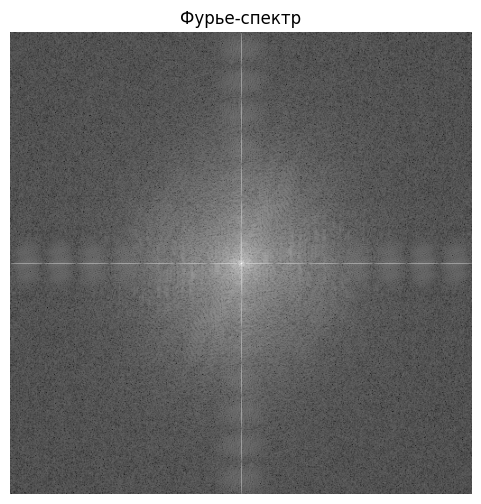

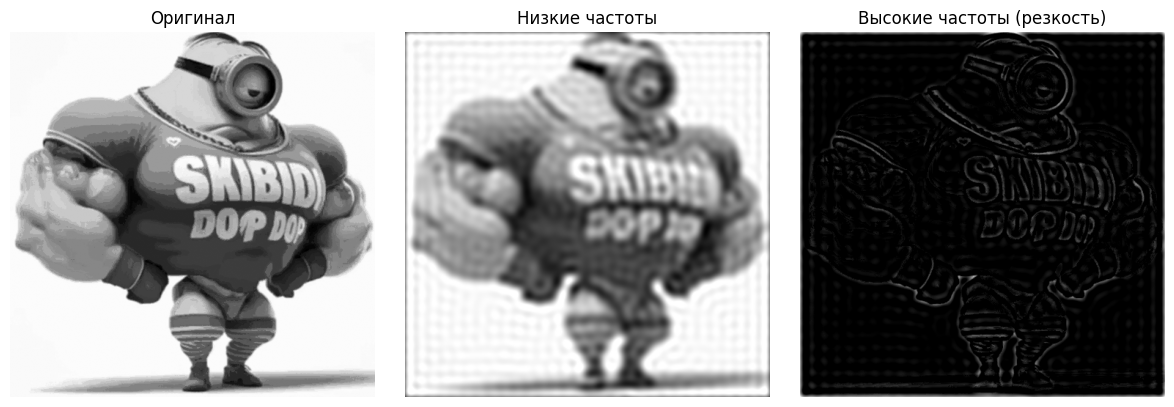

In [144]:
# Построим логарифм спектра
plot_fourier_spectrum(gray_image)

# Применим фильтрацию
lowpass = apply_frequency_filter(gray_image, filter_type='low', radius=30)
highpass = apply_frequency_filter(gray_image, filter_type='high', radius=30)

# Отобразим результат
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(gray_image, cmap='gray')
plt.title("Оригинал")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(lowpass, cmap='gray')
plt.title("Низкие частоты")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(highpass, cmap='gray')
plt.title("Высокие частоты (резкость)")
plt.axis('off')

plt.tight_layout()
plt.show()
